# TO DO:
1. Wrap up one function for feature generation 
2. Wrap up one function for model training 
3. Within the submission API, consider proper concat of cache and new test 
    
    * V1 features are row-based --> don't need cache. 
    * V2 features are based on sec_in_bucket (cross-section feat) --> don't need cache. (Perhaps the gen_v2_features function should be changed to not using groupby() ? )
    * V3 features requires timeseries data -->  the cache is needed.
    * The cache should save the timeseries records of all stocks with sufficient length. 
    * The row after concat should be re-ordered. 
    * After calculate features, only the current seconds_in_bucket should be returned. 
    * Standarization: in the training phase, the standarization is implemented on a multi-day scale. In the cached dataset, only limited timesteps are used in Standarization. 
    * Standarization: during training, perhaps we should perform Standarization on cross-section only. 


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from itertools import combinations
import seaborn as sns
import os, sys, warnings
from time import time 
from create_feature import *

import lightgbm as lgb
import joblib, gc
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from glob import glob

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [15]:
def calc_feature_importance(models, feature_cols):

    df_importance = []
    
    for model in models:
        feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_cols})
        feature_imp.sort_values(by='Value', ascending=False, inplace=True)
        df_importance.append(feature_imp)
        
    df_importance = pd.concat(df_importance)
    df_importance = df_importance.groupby('Feature').mean().reset_index()

    df_importance.sort_values(by='Value', ascending=False, inplace=True)
    df_importance = df_importance.reset_index(drop=True)
    
    return df_importance

In [2]:
feature_dicts = {
    'prices': ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"],
    'sizes':  ["matched_size", "bid_size", "ask_size", "imbalance_size"],
    "category": ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag']
    }

In [ ]:
def prepare_data(csv_file, feature_dicts, nrows=None, save_csv=None):
    
    df = pd.read_csv("../data/train.csv", nrows=None)
    df = df[~df['target'].isnull()] 

    print(df.shape)
    print(f"Trading days: {df['date_id'].nunique()}")
    print(f"Stocks: {df['stock_id'].nunique()}")

    df_final, feature_dicts = gen_features(df, feature_dicts)
    
    if save_csv:
        df_final.to_csv(save_csv, index=False)
    
    return df_final, feature_dicts

In [23]:
feature_cols, category_cols = gen_feature_cols(feature_dicts)

print(len(feature_cols))
print(len(category_cols))
    

460
8


In [ ]:
model_prefix = "lgb_regressor"
model_files = glob(f"../data/{model_prefix}_fold_*.pkl")

models = [joblib.load(model_file) for model_file in model_files]

df_importance = calc_feature_importance(models, feature_cols)

print(np.percentile(df_importance['Value'].values, 20))

imp_thred = 180

less_important = df_importance[df_importance['Value'] < imp_thred]

less_important

In [26]:
feature_cols = [col for col in feature_cols if col not in less_important['Feature'].values]
category_cols = [col for col in category_cols if col not in less_important['Feature'].values]

print(len(feature_cols))

364


In [7]:
# set lgb parameters
lgb_params = {
    'learning_rate': 0.009,#0.018,
    'max_depth': 10,#9,
    'n_estimators': 700,#600,
    'num_leaves': 500,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 24
    }

In [8]:
scale_cols = [x for x in feature_cols if x not in category_cols]
scaler = StandardScaler()
scaler_train = scaler.fit(df_final[scale_cols])
df_final[scale_cols] = scaler_train.transform(df_final[scale_cols])

scaler_filename = "../data/scaler_feature_reduce.pkl"
joblib.dump(scaler_train, scaler_filename)

['../data/scaler_feature_reduce.pkl']

In [9]:
# check if there is any missing values or infinite values
check_invalid_values = pd.DataFrame(columns=['null', 'inf'])
for col in df.columns:
    try:
        check_invalid_values.loc[col] = [df_final[col].isnull().sum(), np.isinf(df_final[col]).sum()]
    except:
        print("Skip column: ", col)
        pass
    
check_invalid_values.T


Skip column:  row_id


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,imbalance_intensity,matched_intensity,price_spread,market_urgency,depth_pressure,price_pressure,imbalance_with_flag,reference_price_far_price_imbalance,reference_price_near_price_imbalance,reference_price_ask_price_imbalance,reference_price_bid_price_imbalance,reference_price_wap_imbalance,far_price_near_price_imbalance,far_price_ask_price_imbalance,far_price_bid_price_imbalance,far_price_wap_imbalance,near_price_ask_price_imbalance,near_price_bid_price_imbalance,near_price_wap_imbalance,ask_price_bid_price_imbalance,ask_price_wap_imbalance,bid_price_wap_imbalance,minute,imb_buy_side,imb_sell_side,first_half_session,second_half_session
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
inf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# CV strategy: KFold
# split train and valid set by date_id
# Within each fold, a continuous period of n days is used as validation set
# The start date of validation set is shifted by n day for each fold
# n = total_days / n_fold

k_fold = KFold(n_splits=5, shuffle=False, random_state=None)
kf_split = k_fold.split(df['date_id'].unique())

mae_scores = []
models = []

model_name_prefix = "lgb_regressor_feature_364"

for fold, (train_dates, valid_dates) in enumerate(kf_split):
    
    print(f"Fold {fold+1}")
    fold_start = time()
    
    # split train and valid set
    df_train = df_final[df_final["date_id"].isin(train_dates)]
    df_valid = df_final[df_final["date_id"].isin(valid_dates)]
    
    print(f"Train : {df_train.shape}, Valid : {df_valid.shape}")
    
    ds_kwargs = {"feature_name": feature_cols, "categorical_feature": category_cols}
    x_train, y_train = df_train[feature_cols], df_train['target']
    x_valid, y_valid = df_valid[feature_cols], df_valid['target']
    
    print(f"Train : {x_train.shape}, Valid : {x_valid.shape}")
    print(f"Data preparation finished. Start training...")
    
    training_start = time()
    
    # model = lgb.train(lgb_params, train_data, valid_sets=[train_data, valid_data])
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    
    lgb_model.fit(
        x_train, 
        y_train,
        eval_set=[(x_valid, y_valid)],
        feature_name = feature_cols,
        categorical_feature = category_cols,
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
            ],
        )
    
    models.append(lgb_model)
    
    model_file = f"../data/{model_name_prefix}_fold_{fold+1}.pkl" 
    joblib.dump(lgb_model, model_file)
    
    print(f"Fold {fold+1} Trainning finished. Time elapsed: {time()-training_start:.2f}s")
    
    y_pred_valid = lgb_model.predict(x_valid)
    print(y_pred_valid)
    mae = mean_absolute_error(y_valid, y_pred_valid)
    mae_scores.append(mae)

    print(f"Fold {fold+1} MAE: {mae}")
    print(f"Fold {fold+1} Time elapsed: {time()-fold_start:.2f}s")
    
    del df_train, df_valid, x_train, y_train, x_valid, y_valid
    gc.collect()

print(f"Overall MAE: {np.mean(mae_scores)}")
print("Done!")

Fold 1
Train : (4203153, 464), Valid : (1034739, 464)
Train : (4203153, 364), Valid : (1034739, 364)
Data preparation finished. Start training...
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92320
[LightGBM] [Info] Number of data points in the train set: 4203153, number of used features: 364
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score -0.060201
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 5.74503
[200]	valid_0's l1: 5.71

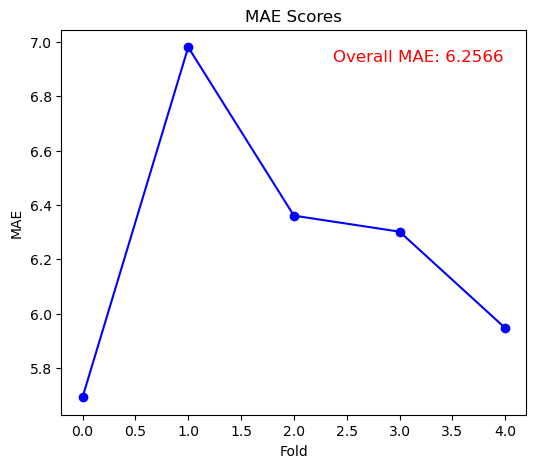

In [11]:
# plot mae scores
plt.figure(figsize=(6, 5))

plt.plot(mae_scores, marker='o', color='blue', label='MAE')
plt.text(0.95, 0.95, f"Overall MAE: {np.mean(mae_scores):.4f}", fontsize=12, ha='right', va='top', color='red', transform=plt.gca().transAxes)
plt.title('MAE Scores')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.show()


In [29]:
model_prefix = "lgb_regressor_feature_364"
model_files = glob(f"../data/{model_prefix}_fold_*.pkl")

models = [joblib.load(model_file) for model_file in model_files]

df_importance = calc_feature_importance(models, feature_cols)

print(np.percentile(df_importance['Value'].values, 20))

imp_thred = 310

less_important = df_importance[df_importance['Value'] < imp_thred]

less_important

312.08000000000004


,Feature,Value
292,rank_bid_size,309.6
293,mean_imbalance_intensity_5,309.6
294,rank_near_price_ask_price_imbalance,308.6
295,mean_far_price_5,308.0
296,std_matched_intensity_5,307.8
297,max_near_price_wap_imbalance_5,307.4
298,min_volume,305.0
299,std_mid_price,303.2
300,std_price_spread_5,303.2
301,max_reference_price_ask_price_imbalance,302.6


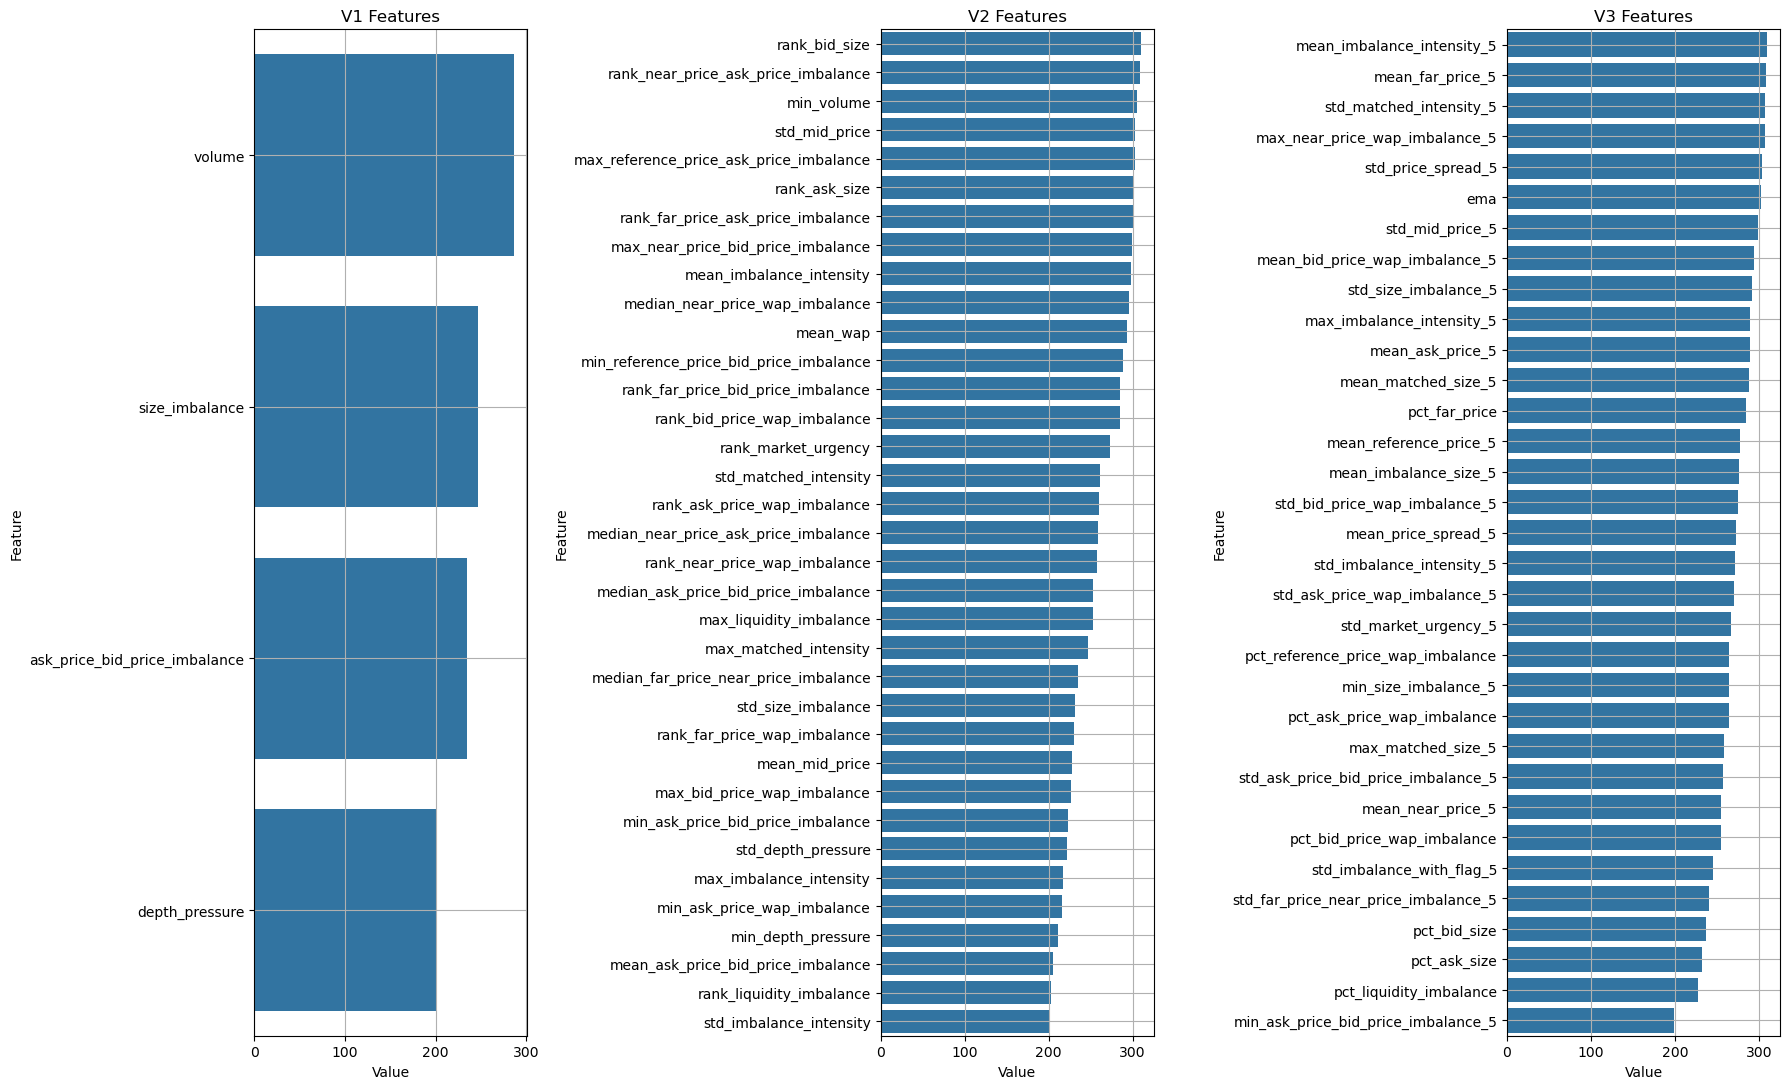

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 11))

less_imp_v1 = less_important[less_important['Feature'].isin(feature_dicts['v1_features']+feature_dicts['v1_feature_category'])]
less_imp_v2 = less_important[less_important['Feature'].isin(feature_dicts['v2_features'])]
less_imp_v3 = less_important[less_important['Feature'].isin(feature_dicts['v3_features'])]

for i, (ax, df_lss) in enumerate(zip(axes, [less_imp_v1, less_imp_v2, less_imp_v3])):
    sns.barplot(x="Value", y="Feature", data=df_lss, ax=ax)
    ax.grid()
    ax.set_title(f"V{i+1} Features")
# ax.set_xlim(0, 2000)
plt.tight_layout()
plt.show()

In [ ]:
# imb_cols = [x for x in feature_dicts['v3_features'] if 'imbalance' in x]
# non_imb_cols = [x for x in feature_dicts['v3_features'] if 'imbalance' not in x]


mean_features = [x for x in feature_dicts['v3_features'] if 'mean_' in x]
std_features = [x for x in feature_dicts['v3_features'] if 'std_' in x]

imp_mean = df_importance[df_importance['Feature'].isin(mean_features)]
imp_std = df_importance[df_importance['Feature'].isin(std_features)]

fig, axes = plt.subplots(1, 2, figsize=(12, 11))
sns.barplot(x="Value", y="Feature", data=imp_mean, ax=axes[0])
sns.barplot(x="Value", y="Feature", data=imp_std, ax=axes[1])
plt.xticks(rotation='vertical')
for ax in axes:
    ax.grid()
    ax.set_xlim(0, 2000)
plt.tight_layout()
plt.show()

In [ ]:
max_features = [x for x in feature_dicts['v3_features'] if 'max_' in x]
min_features = [x for x in feature_dicts['v3_features'] if 'min_' in x]

imp_max = df_importance[df_importance['Feature'].isin(max_features)]
imp_min = df_importance[df_importance['Feature'].isin(min_features)]

fig, axes = plt.subplots(1, 2, figsize=(12, 11))
sns.barplot(x="Value", y="Feature", data=imp_max, ax=axes[0])
sns.barplot(x="Value", y="Feature", data=imp_min, ax=axes[1])
plt.xticks(rotation='vertical')
for ax in axes:
    ax.grid()
    ax.set_xlim(0, 2000)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, RFECV

# select features using RFECV
rfecv = RFECV(estimator=lgb_model, step=1, cv=5, scoring='neg_mean_absolute_error', verbose=2)



In [ ]:
# CV strategy: KFold
# split train and valid set by date_id
# Within each fold, a continuous period of n days is used as validation set
# The start date of validation set is shifted by n day for each fold
# n = total_days / n_fold

# remove the least important features (based on feature importance)
remove_features = feature_imp.iloc[-10:].Feature.tolist()

k_fold = KFold(n_splits=5, shuffle=False, random_state=None)
kf_split = k_fold.split(df['date_id'].unique())

mae_scores = []
models = []

feature_names = [x for x in categorical_cols + feature_cols if x not in remove_features]
feature_cols_less = [x for x in feature_cols if x not in remove_features]
categorical_cols_less = [x for x in categorical_cols if x not in remove_features]

print(f"Length of feature names: {len(feature_names)}")

for fold, (train_dates, valid_dates) in enumerate(kf_split):
    
    print(f"Fold {fold+1}")
    fold_start = time()
    
    # split train and valid set
    df_train = df[df["date_id"].isin(train_dates)]
    df_valid = df[df["date_id"].isin(valid_dates)]
    
    print(f"Train : {df_train.shape}, Valid : {df_valid.shape}")
    
    df_train_feature = df_train[feature_names]
    df_train_feature = standardize(df_train_feature, feature_cols_less)
    
    print(f"Train feature: {x_train.shape}, Train target: {y_train.shape}")
    
    df_valid_feature = df_valid[feature_names]
    df_valid_feature = standardize(df_valid_feature, feature_cols_less)
    
    print(f"Valid feature: {x_valid.shape}, Valid target: {y_valid.shape}")
    
    print(f"Data preparation finished. Time elapsed: {time()-fold_start:.2f}s")
    
    print("Start training...")
    training_start = time()
    
    # model = lgb.train(lgb_params, train_data, valid_sets=[train_data, valid_data])
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        df_train_feature, 
        df_train['target'],
        eval_set=[(df_valid_feature, df_valid['target'])],
        feature_name = feature_names,
        categorical_feature = categorical_cols_less,
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
            ],
        )
    
    models.append(lgb_model)
    
    model_file = f"../data/lgb_regressor_fold_{fold+1}_feat_400.pkl" 
    joblib.dump(lgb_model, model_file)
    
    print(f"Fold {fold+1} Trainning finished. Time elapsed: {time()-training_start:.2f}s")
    
    y_pred_valid = lgb_model.predict(df_valid_feature)
    mae = mean_absolute_error(df_valid['target'], y_pred_valid)
    mae_scores.append(mae)

    print(f"Fold {fold+1} MAE: {mae}")
    print(f"Fold {fold+1} Time elapsed: {time()-fold_start:.2f}s")
    
    del df_train, df_valid, df_train_feature, df_valid_feature
    gc.collect()

print(f"Overall MAE: {np.mean(mae_scores)}")
print("Done!")

In [ ]:
# plot mae scores
plt.figure(figsize=(6, 5))

plt.plot(mae_scores, marker='o', color='blue', label='MAE')
plt.text(0.95, 0.95, f"Overall MAE: {np.mean(mae_scores):.4f}", fontsize=12, ha='right', va='top', color='red', transform=plt.gca().transAxes)
plt.title('MAE Scores')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.show()

In [ ]:
# A simple validation split: keep the last 45 days for validation

# split_day = 435
# df_train = df[df["date_id"] <= split_day]
# df_valid = df[df["date_id"] > split_day]
# print(f"Train : {df_train.shape}, Valid : {df_valid.shape}")

# df_train_feature = df_train[categorical_cols + feature_cols]
# df_train_target = df_train["target"]

# df_valid_feature = df_valid[categorical_cols + feature_cols]
# df_valid_target = df_valid["target"]

# print(f"Train feature: {df_train_feature.shape}, Train target: {df_train_target.shape}")
# print(f"Valid feature: {df_valid_feature.shape}, Valid target: {df_valid_target.shape}")